# References 

code - https://github.com/YeonwooSung/PyTorch_CNN_Architectures/blob/master/models/resnet.py


paper - [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.

    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from IPython import display as disp
from torch import optim
from torch.optim.lr_scheduler import CyclicLR



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
device

device(type='cuda')

In [3]:
# helper function to make getting another batch of data easier
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Add horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2675, 0.2565, 0.2761))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2675, 0.2565, 0.2761))
])

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform= train_transform),
    batch_size=(256), shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform= test_transform),
    batch_size=(256), drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

100%|██████████| 169001437/169001437 [00:05<00:00, 29331232.30it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


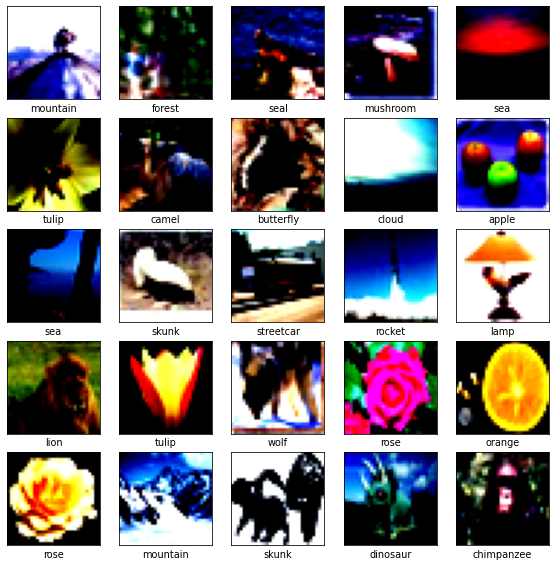

In [4]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

In [5]:
class Simpleblock(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(n, n, 3, 1, 1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, 3, 1, 1),
            nn.BatchNorm2d(n)
        )

    def forward(self, x):
        return torch.relu(x + self.block(x))

class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(BottleneckResidualBlock, self).__init__()
        self.reduce = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.process = nn.Sequential(
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )
        self.expand = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.adjust_channels = nn.Sequential()
        if in_channels != out_channels:
            self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        identity = self.adjust_channels(x)
        reduced = self.reduce(x)
        processed = self.process(reduced)
        expanded = self.expand(processed)
        out = expanded + identity
        return F.relu(out)

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.relu1 = nn.ReLU()

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)  
        self.bn2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3 + Residual Block
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1) 
        self.bn3 = nn.BatchNorm2d(40)
        self.relu3 = nn.ReLU()
        self.block1 = Simpleblock(40)  
        self.dropout3 = nn.Dropout(0.5)

        # Convolutional Block 4 + Residual Block
        self.conv4 = nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1) 
        self.bn4 = nn.BatchNorm2d(40)
        self.relu4 = nn.ReLU()
        self.block2 = Simpleblock(40) 
        self.dropout4 = nn.Dropout(0.5)

        self.bottleneck_block = BottleneckResidualBlock(40, 34, 40)
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(40, 100)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.block1(self.relu3(self.bn3(self.conv3(x))))
        x = self.block2(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.bottleneck_block(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

N = MyCNN().to(device)
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=10, factor=0.1, min_lr=0.00001, verbose=True)

print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')
plot_data = []
steps = 0


> Number of parameters 99440


steps: 10000.00, train loss: 1.479, train acc: 0.573±0.030, test acc: 0.501±0.032


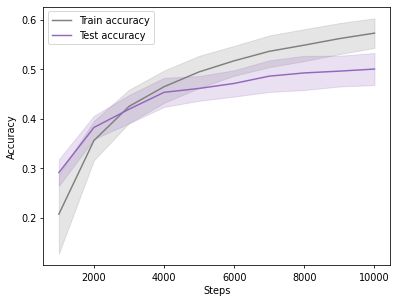

In [6]:
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N((x))
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N((x))
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # print loss and accuracy data
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

    # plot accuracy graph 
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)